## Necessary module import

In [1]:
## Imports
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import h5py
import pandas as pd
import ast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchinfo import summary
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

In [4]:
# Set random seed for Workspace
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Input data construction

In [5]:
## Geomodel description, permx, permz, porosity
nt, nx, ny, nz = 11, 35, 35, 11

geomodel = {}
kxy = np.genfromtxt('Geomodel_base/tables/permTable').reshape((nx, ny, nz)) * 1.01324997e+15 
kz = np.genfromtxt('Geomodel_base/tables/permZTable').reshape((nx, ny, nz)) * 1.01324997e+15 
phi = np.genfromtxt('Geomodel_base/tables/poroTable').reshape((nx, ny, nz))

kxy = (kxy - kxy.min()) / (kxy.max() - kxy.min() + 1e-8)
kz  = (kz  - kz.min())  / (kz.max() - kz.min() + 1e-8)
phi = (phi - phi.min()) / (phi.max() - phi.min() + 1e-8)

geomodel["permxy"] = kxy
geomodel["permz"] = kz
geomodel["phi"] = phi


In [6]:
# metadata for well locations and well rates
meta = pd.read_csv('dataset_3/run_log.csv', index_col='run_id')
meta['well_coords'] = (meta['well_coords'].apply(ast.literal_eval))
meta['rate_matrix'] = meta['rate_matrix'].apply(ast.literal_eval)
meta['rate_matrix'] = meta['rate_matrix'].apply(lambda x: np.array(x, dtype=float))

def map_coord_to_index(x, x_max=11200, n=35):
    #return int(np.clip(round((x / x_max) * (n - 1)), 0, n - 1))
    return int(round((x / x_max) * (n - 1)))

meta['well_coords'] = meta['well_coords'].apply(
    lambda wells: [(map_coord_to_index(x), map_coord_to_index(y)) for (x, y) in wells]
)


In [9]:
# First, extract the run IDs and ensemble labels
run_ids = meta.index.values
ensembles = meta['ensemble'].values

# train/dev/test set id split
# We’ll stratify by ensemble so each subset has a mix of A, B, C
train_ids, temp_ids = train_test_split(
    run_ids, test_size=0.8, random_state=42, stratify=ensembles)
dev_ids, test_ids = train_test_split(
    temp_ids, test_size=0.5, random_state=42, stratify=meta.loc[temp_ids, 'ensemble'])

print(f"Train: {len(train_ids)} runs, Dev: {len(dev_ids)}, Test: {len(test_ids)}")

Train: 1 runs, Dev: 2, Test: 2


In [8]:
# load training, dev, test, splits from previously saved file
splits = np.load('split_ids.npz')
train_ids, dev_ids, test_ids = splits['train'], splits['dev'], splits['test']

In [10]:
h5path = ['h5_outputs/Training_data_1.h5', 'h5_outputs/Training_data_2.h5']
# Determine the global P_sigma and P_mu across all runs
P_list, S_list = [], []
for p in h5path:
    with h5py.File(p, 'r') as hf:
        P_list.append(hf['pressure'][...])    # (n, Nt, 35, 35, 11)
        S_list.append(hf['saturation'][...])  # (n, Nt, 35, 35, 11)
P_all = np.concatenate(P_list, axis=0)
S_all = np.concatenate(S_list, axis=0)

P_MU, P_SIGMA = float(P_all.mean()), float(P_all.std() + 1e-8)

In [11]:
# Define the class that will process the input data to X, Y format

CONTROL_STEPS = [0, 1, 2]  # k indices with nonzero injection: 0→5, 5→10, 10→15
P_MU = P_MU
P_SIGMA = P_SIGMA

class GEOSFiveYearDatasetSimple(Dataset):
    """
    - Expects 1+ HDF5 files each with datasets 'pressure' and 'saturation':
        shape (n, Nt=11, 35, 35, 11)
    - meta is a pandas.DataFrame indexed by run_id (1..n_total) with:
        - well_coords: list[(xi, yi), (xi, yi), (xi, yi)] in GRID INDICES (0..34)
        - rate_matrix: np.array shape (3, 3) -> rows are 5-yr periods 0–5, 5–10, 10–15
          values are absolute rates or fractions (consistent with simulations)
    - geomodel: dict with arrays 'permxy', 'permz', 'phi' of shape (35, 35, 11)
    """
    def __init__(self, h5_paths, meta, geomodel, normalize=True, add_time_channels=False):
        self.meta = meta.sort_index() 
        self.geomodel = geomodel
        self.normalize = normalize
        self.add_time = add_time_channels

        # Load and concatenate H5 datasets
        P_list, S_list = [], []
        for p in h5_paths:
            with h5py.File(p, 'r') as hf:
                P_list.append(hf['pressure'][...])    # (n, Nt, 35, 35, 11)
                S_list.append(hf['saturation'][...])  # (n, Nt, 35, 35, 11)
        P_all = np.concatenate(P_list, axis=0)
        S_all = np.concatenate(S_list, axis=0)
        
        
        selected_ids = self.meta.index.values  # run_id values (1-based)
        self.P = P_all[selected_ids - 1]       # zero-based indexing
        self.S = S_all[selected_ids - 1]
        self.n, self.Nt = self.P.shape[:2]  # Nt should be 11 (0..50 every 5y)
        assert self.Nt == 11, f"Expected Nt=11, got {self.Nt}"

        # Precompute well masks per run: (n, 3, 35, 35, 11)
        self.masks = self._build_well_masks()

        # Normalization stats
        if self.normalize:
            self.P_mu, self.P_sigma = P_MU, P_SIGMA
            # self.P_mu, self.P_sigma = float(self.P.mean()), float(self.P.std() + 1e-8)
            self.S_mu, self.S_sigma = float(self.S.mean()), float(self.S.std() + 1e-8)
        else:
            self.P_mu = self.P_sigma = self.S_mu = self.S_sigma = 0.0

        # Extract statics
        self.kxy = self.geomodel['permxy'].astype(np.float32)      # (35,35,11)
        self.kz  = self.geomodel['permz'].astype(np.float32)       # (35,35,11)
        self.phi = self.geomodel['phi'].astype(np.float32)         # (35,35,11)

    def _build_well_masks(self):
        masks = np.zeros((self.n, 1, 35, 35, 11), dtype=np.float32)
        for i, run_id in enumerate(self.meta.index):
            coords = self.meta.loc[run_id, 'well_coords']
            for w, (xi, yi) in enumerate(coords):
                xi = int(np.clip(round(xi), 0, 34))
                yi = int(np.clip(round(yi), 0, 34))
                masks[i, :, xi, yi, :] = 1.0  # full vertical column
        return masks

    def __len__(self):
        return self.n * (self.Nt - 1)  # 10 transitions per run

    def __getitem__(self, idx):
        run = idx // (self.Nt - 1)
        k   = idx %  (self.Nt - 1)  # transition k: t_k -> t_{k+1}; k=0..9
        t_k = 5.0 * k

        Pk  = self.P[run, k].astype(np.float32)    # (35,35,11)
        Sk  = self.S[run, k].astype(np.float32)
        Pk1 = self.P[run, k+1].astype(np.float32)
        Sk1 = self.S[run, k+1].astype(np.float32)

        if self.normalize:
            Pk  = (Pk  - self.P_mu) / self.P_sigma
            #Sk  = (Sk  - self.S_mu) / self.S_sigma
            Pk1 = (Pk1 - self.P_mu) / self.P_sigma
            #Sk1 = (Sk1 - self.S_mu) / self.S_sigma

        # statics
        kxy, kz, phi = self.kxy, self.kz, self.phi

        # masks for this run (1,35,35,11)
        masks = self.masks[run]

        # rates for this step: if k in {0,1,2}, use row k; else zeros
        rm = np.array(self.meta.loc[self.meta.index[run], 'rate_matrix'])
        if k in CONTROL_STEPS:
            step_rates = rm[k]
        else:
            step_rates = np.zeros(3, dtype=np.float32)
        step_rates = step_rates / 67.9010535
        
        rate_field = np.zeros_like(Pk, dtype=np.float32)
        coords = self.meta.loc[self.meta.index[run], 'well_coords']
        for w, (xi, yi) in enumerate(coords):
            xi = int(np.clip(round(xi), 0, 34))
            yi = int(np.clip(round(yi), 0, 34))
            rate_field[xi, yi, :] = float(step_rates[w])
        rate_ch = np.expand_dims(rate_field, axis=0)


        # optional time channels
        extras = []
        if self.add_time:
            dt_ch = np.full_like(Pk, 5.0)  # Δt = 5 years
            t_ch  = np.full_like(Pk, t_k)
            extras = [np.stack([dt_ch, t_ch], axis=0)]  # (2,35,35,11)

        # assemble input channels
        # Note that permxy, permz and phi are not included
        X = np.stack([Pk, Sk], axis=0)     # (2,35,35,11)
        X = np.concatenate([X, masks, rate_ch] + extras, axis=0)  # (~2+1+1 [+2])

        Y = np.stack([Pk1, Sk1], axis=0)                 # (2,35,35,11)

        # Return as torch tensors with channel-first (C, X, Y, Z)
        X = torch.from_numpy(X).float()  # (C,35,35,11)
        Y = torch.from_numpy(Y).float()  # (2,35,35,11)
        return X, Y


In [13]:
# Build train, dev and test set
meta_train = meta.loc[train_ids]
meta_dev   = meta.loc[dev_ids]
meta_test  = meta.loc[test_ids]
train_dataset = GEOSFiveYearDatasetSimple(h5path, meta_train, geomodel)
dev_dataset   = GEOSFiveYearDatasetSimple(h5path, meta_dev, geomodel)
test_dataset  = GEOSFiveYearDatasetSimple(h5path, meta_test, geomodel)

In [17]:
# Create the training and dev data loader
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=10, shuffle=False)

## Model

In [20]:
# -------------------------------------------------------------
#  Basic residual block (3D)
# -------------------------------------------------------------
class ResBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm3d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm3d(out_ch)
        self.relu2 = nn.ReLU(inplace=True)

        self.skip = (
            nn.Conv3d(in_ch, out_ch, kernel_size=1, bias=False)
            if in_ch != out_ch else nn.Identity()
        )

        # Kaiming initialization
        for m in [self.conv1, self.conv2]:
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if isinstance(self.skip, nn.Conv3d):
            nn.init.kaiming_normal_(self.skip.weight, nonlinearity='relu')

    def forward(self, x):
        residual = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu2(out)
        return out



# -------------------------------------------------------------
#  Downsample block (encoder path)
# -------------------------------------------------------------
class DownBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.down = nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=2, padding=1)
        self.res = ResBlock3D(out_ch, out_ch)
        nn.init.kaiming_normal_(self.down.weight, nonlinearity='relu')
        if self.down.bias is not None:
            nn.init.zeros_(self.down.bias)

    def forward(self, x):
        x = self.down(x)
        x = self.res(x)
        return x


# -------------------------------------------------------------
#  Upsample block (decoder path)
# -------------------------------------------------------------
class UpBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # interpolate + 1×1×1 conv to reduce channels
        self.conv1x1 = nn.Conv3d(in_ch, out_ch, kernel_size=1)
        self.res = ResBlock3D(out_ch * 2, out_ch)  # after concat with skip
        nn.init.kaiming_normal_(self.conv1x1.weight, nonlinearity='relu')
        if self.conv1x1.bias is not None:
            nn.init.zeros_(self.conv1x1.bias)

    def forward(self, x, skip):
        # Trilinear upsample
        x = F.interpolate(x, size=skip.shape[2:], mode='trilinear', align_corners=False)
        x = self.conv1x1(x)
        x = torch.cat([x, skip], dim=1)
        x = self.res(x)
        return x


# -------------------------------------------------------------
#  Full 3D Residual U-Net
# -------------------------------------------------------------
class ResUNet3D(nn.Module):
    def __init__(self, in_ch=4, base_ch=32, out_ch=2):
        super().__init__()

        # Encoder
        self.enc1 = ResBlock3D(in_ch, base_ch)          # 11 → 32
        self.down1 = DownBlock3D(base_ch, base_ch * 2)  # 32 → 64
        self.down2 = DownBlock3D(base_ch * 2, base_ch * 4)  # 64 → 128
        self.down3 = DownBlock3D(base_ch * 4, base_ch * 8)  # 128 → 256
        self.down4 = DownBlock3D(base_ch * 8, base_ch * 12) # 256 → 384 (bottleneck)

        # Decoder
        self.up1 = UpBlock3D(base_ch * 12, base_ch * 8)  # 384 → 256
        self.up2 = UpBlock3D(base_ch * 8,  base_ch * 4)  # 256 → 128
        self.up3 = UpBlock3D(base_ch * 4,  base_ch * 2)  # 128 → 64
        self.up4 = UpBlock3D(base_ch * 2,  base_ch)      # 64  → 32

        # Output heads
        self.head_p = nn.Sequential(
            nn.Conv3d(base_ch, base_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(base_ch, 1, kernel_size=1)
        )
        self.head_s = nn.Sequential(
            nn.Conv3d(base_ch, base_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(base_ch, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Weight initialization
        for m in [self.head_p[0], self.head_p[2], self.head_s[0], self.head_s[2]]:
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)        # 32
        e2 = self.down1(e1)      # 64
        e3 = self.down2(e2)      # 128
        e4 = self.down3(e3)      # 256
        b  = self.down4(e4)      # 384 bottleneck

        # Decoder
        d1 = self.up1(b, e4)     # 256
        d2 = self.up2(d1, e3)    # 128
        d3 = self.up3(d2, e2)    # 64
        d4 = self.up4(d3, e1)    # 32

        # Heads
        p = self.head_p(d4)
        s = self.head_s(d4)
        out = torch.cat([p, s], dim=1)  # (B,2,35,35,11)
        return out

In [21]:
# Instantiate model
C_in = 4   # number of input channels 
C_out = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the network
torch.manual_seed(SEED)
model = ResUNet3D(in_ch=C_in, base_ch=32, out_ch=C_out).to(device)

In [22]:
# print out model summary
summary(model,input_size=(1,4, 35, 35, 11), device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
ResUNet3D                                [1, 2, 35, 35, 11]        --
├─ResBlock3D: 1-1                        [1, 32, 35, 35, 11]       --
│    └─Conv3d: 2-1                       [1, 32, 35, 35, 11]       128
│    └─Conv3d: 2-2                       [1, 32, 35, 35, 11]       3,456
│    └─BatchNorm3d: 2-3                  [1, 32, 35, 35, 11]       64
│    └─ReLU: 2-4                         [1, 32, 35, 35, 11]       --
│    └─Conv3d: 2-5                       [1, 32, 35, 35, 11]       27,648
│    └─BatchNorm3d: 2-6                  [1, 32, 35, 35, 11]       64
│    └─ReLU: 2-7                         [1, 32, 35, 35, 11]       --
├─DownBlock3D: 1-2                       [1, 64, 18, 18, 6]        --
│    └─Conv3d: 2-8                       [1, 64, 18, 18, 6]        55,360
│    └─ResBlock3D: 2-9                   [1, 64, 18, 18, 6]        --
│    │    └─Identity: 3-1                [1, 64, 18, 18, 6]        --
│  

In [23]:
# ---------------------------
# Loss function
# ---------------------------
def loss_fn(pred, target, lambda_s=1.0, plume_tau=0.02, plume_w=10):
    """
    pred, target: tensors of shape (B, 2, 35, 35, 11)
    lambda_s: weighting factor for saturation term
    """
    # Split into pressure and saturation channels
    P_pred, S_pred = pred[:, 0], pred[:, 1]
    P_true, S_true = target[:, 0], target[:, 1]
    
    # L1 loss for each field
    loss_p = F.mse_loss(P_pred, P_true)
    #loss_s = F.mse_loss(S_pred, S_true)
    w = torch.ones_like(S_true)
    w = torch.where(S_true > plume_tau, torch.full_like(w, plume_w), w)
    loss_s = (w * (S_pred - S_true)**2).mean()
    
    
    total_loss = loss_p + lambda_s * loss_s 
    return total_loss, loss_p.item(), loss_s.item()


In [24]:
# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=5,
                                                 verbose=True)

In [26]:
# Ensure both model and optimizer have the same id
print("model param id:", id(list(model.parameters())[0]))
print("opt   param id:", id(optimizer.param_groups[0]['params'][0]))

model param id: 140288814453200
opt   param id: 140288814453200


##  Training/Validation Loop

In [27]:
# Track metrics across epochs
train_total_hist, val_total_hist = [], []
train_p_hist, train_s_hist = [], []
val_p_hist, val_s_hist = [], []

# ---------------------------
# Configuration
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 200
lambda_s = 1.0      # weight for saturation term
log_interval = 4000   # print every N batches

# Move model to GPU/CPU
model = model.to(device)

# ---------------------------
# Training and validation loops
# ---------------------------
def train_one_epoch(model, dataloader, optimizer, lambda_s=1.0):
    model.train()
    running_loss, running_p, running_s = 0.0, 0.0, 0.0

    for batch_idx, (X, Y) in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        X, Y = X.to(device), Y.to(device)

        # Forward
        pred = model(X)
        loss, loss_p, loss_s = loss_fn(pred, Y, lambda_s=lambda_s)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping
        optimizer.step()

        running_loss += loss.item()
        running_p += loss_p
        running_s += loss_s

        if (batch_idx + 1) % log_interval == 0:
            print(f"  [Batch {batch_idx+1}/{len(dataloader)}] "
                  f"Loss: {loss.item():.4f} | L_P: {loss_p:.4f} | L_S: {loss_s:.4f}")

    n = len(dataloader)
    return running_loss / n, running_p / n, running_s / n


@torch.no_grad()
def evaluate(model, dataloader, lambda_s=1.0):
    model.eval()
    total_loss, total_p, total_s = 0.0, 0.0, 0.0

    for X, Y in tqdm(dataloader, desc="Validation", leave=False):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        loss, loss_p, loss_s = loss_fn(pred, Y, lambda_s=lambda_s)
        total_loss += loss.item()
        total_p += loss_p
        total_s += loss_s

    n = len(dataloader)
    return total_loss / n, total_p / n, total_s / n


# ---------------------------
# Main training loop
# ---------------------------
best_val_loss = float('inf')

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    train_loss, train_p, train_s = train_one_epoch(model, train_loader, optimizer, lambda_s)
    torch.cuda.empty_cache()
    val_loss, val_p, val_s = evaluate(model, dev_loader, lambda_s)
    torch.cuda.empty_cache()

    print(f"  Train: L={train_loss:.6f} | L_P={train_p:.6f} | L_S={train_s:.6f}")
    print(f"  Valid: L={val_loss:.6f} | L_P={val_p:.6f} | L_S={val_s:.6f}")

    # Record history
    train_total_hist.append(train_loss)
    val_total_hist.append(val_loss)
    train_p_hist.append(train_p)
    train_s_hist.append(train_s)
    val_p_hist.append(val_p)
    val_s_hist.append(val_s)

    if 'scheduler' in locals():
        scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_resunet3d_13.pt")
        print("Saved new best model")

end_time = time.time()
training_time = end_time - start_time
print("Training time: %.4f" %(training_time))
print("\nTraining complete. Best validation loss:", best_val_loss)



Epoch 1/200


  Train: L=0.092575 | L_P=0.077549 | L_S=0.015027
  Valid: L=0.046940 | L_P=0.040643 | L_S=0.006296
Saved new best model

Epoch 2/200


  Train: L=0.023350 | L_P=0.018999 | L_S=0.004350
  Valid: L=0.016919 | L_P=0.013762 | L_S=0.003157
Saved new best model

Epoch 3/200


  Train: L=0.008699 | L_P=0.006168 | L_S=0.002531
  Valid: L=0.006086 | L_P=0.003903 | L_S=0.002183
Saved new best model

Epoch 4/200


  Train: L=0.005619 | L_P=0.003713 | L_S=0.001905
  Valid: L=0.004556 | L_P=0.002832 | L_S=0.001724
Saved new best model

Epoch 5/200


  Train: L=0.004343 | L_P=0.002779 | L_S=0.001563
  Valid: L=0.003725 | L_P=0.002258 | L_S=0.001467
Saved new best model

Epoch 6/200


  Train: L=0.003819 | L_P=0.002458 | L_S=0.001361
  Valid: L=0.002920 | L_P=0.001671 | L_S=0.001248
Saved new best model

Epoch 7/200


  Train: L=0.002936 | L_P=0.001776 | L_S=0.001160
  Valid: L=0.002423 | L_P=0.001337 | L_S=0.001086
Saved new best model

Epoch 8/200


  Train: L=0.002534 | L_P=0.001512 | L_S=0.001022
  Valid: L=0.002969 | L_P=0.001967 | L_S=0.001002

Epoch 9/200


  Train: L=0.002450 | L_P=0.001535 | L_S=0.000915
  Valid: L=0.003499 | L_P=0.002526 | L_S=0.000973

Epoch 10/200


  Train: L=0.002207 | L_P=0.001384 | L_S=0.000823
  Valid: L=0.001754 | L_P=0.000990 | L_S=0.000764
Saved new best model

Epoch 11/200


  Train: L=0.001914 | L_P=0.001180 | L_S=0.000734
  Valid: L=0.003822 | L_P=0.003109 | L_S=0.000712

Epoch 12/200


  Train: L=0.002314 | L_P=0.001591 | L_S=0.000723
  Valid: L=0.001518 | L_P=0.000881 | L_S=0.000637
Saved new best model

Epoch 13/200


  Train: L=0.001681 | L_P=0.001058 | L_S=0.000623
  Valid: L=0.004027 | L_P=0.002995 | L_S=0.001032

Epoch 14/200


  Train: L=0.001581 | L_P=0.000987 | L_S=0.000594
  Valid: L=0.001270 | L_P=0.000720 | L_S=0.000551
Saved new best model

Epoch 15/200


  Train: L=0.001290 | L_P=0.000760 | L_S=0.000530
  Valid: L=0.001238 | L_P=0.000702 | L_S=0.000537
Saved new best model

Epoch 16/200


  Train: L=0.001291 | L_P=0.000790 | L_S=0.000501
  Valid: L=0.001194 | L_P=0.000718 | L_S=0.000476
Saved new best model

Epoch 17/200


  Train: L=0.001193 | L_P=0.000722 | L_S=0.000471
  Valid: L=0.001071 | L_P=0.000609 | L_S=0.000462
Saved new best model

Epoch 18/200


  Train: L=0.001146 | L_P=0.000699 | L_S=0.000447
  Valid: L=0.001393 | L_P=0.000962 | L_S=0.000430

Epoch 19/200


  Train: L=0.001108 | L_P=0.000685 | L_S=0.000423
  Valid: L=0.001648 | L_P=0.001181 | L_S=0.000467

Epoch 20/200


  Train: L=0.000984 | L_P=0.000586 | L_S=0.000399
  Valid: L=0.000909 | L_P=0.000513 | L_S=0.000397
Saved new best model

Epoch 21/200


  Train: L=0.000894 | L_P=0.000514 | L_S=0.000380
  Valid: L=0.000777 | L_P=0.000398 | L_S=0.000379
Saved new best model

Epoch 22/200


  Train: L=0.000969 | L_P=0.000597 | L_S=0.000372
  Valid: L=0.001183 | L_P=0.000808 | L_S=0.000374

Epoch 23/200


  Train: L=0.000786 | L_P=0.000439 | L_S=0.000347
  Valid: L=0.000736 | L_P=0.000375 | L_S=0.000361
Saved new best model

Epoch 24/200


  Train: L=0.000780 | L_P=0.000446 | L_S=0.000335
  Valid: L=0.000884 | L_P=0.000528 | L_S=0.000356

Epoch 25/200


  Train: L=0.000797 | L_P=0.000469 | L_S=0.000328
  Valid: L=0.000871 | L_P=0.000544 | L_S=0.000327

Epoch 26/200


  Train: L=0.000682 | L_P=0.000372 | L_S=0.000310
  Valid: L=0.000660 | L_P=0.000341 | L_S=0.000320
Saved new best model

Epoch 27/200


  Train: L=0.000689 | L_P=0.000387 | L_S=0.000302
  Valid: L=0.000771 | L_P=0.000459 | L_S=0.000311

Epoch 28/200


  Train: L=0.000707 | L_P=0.000411 | L_S=0.000295
  Valid: L=0.000624 | L_P=0.000324 | L_S=0.000300
Saved new best model

Epoch 29/200


  Train: L=0.000621 | L_P=0.000340 | L_S=0.000281
  Valid: L=0.000733 | L_P=0.000434 | L_S=0.000299

Epoch 30/200


  Train: L=0.000607 | L_P=0.000332 | L_S=0.000275
  Valid: L=0.000678 | L_P=0.000388 | L_S=0.000291

Epoch 31/200


  Train: L=0.000667 | L_P=0.000394 | L_S=0.000273
  Valid: L=0.000747 | L_P=0.000462 | L_S=0.000284

Epoch 32/200


  Train: L=0.000547 | L_P=0.000290 | L_S=0.000257
  Valid: L=0.000527 | L_P=0.000245 | L_S=0.000282
Saved new best model

Epoch 33/200


  Train: L=0.000545 | L_P=0.000292 | L_S=0.000253
  Valid: L=0.000620 | L_P=0.000344 | L_S=0.000276

Epoch 34/200


  Train: L=0.000551 | L_P=0.000302 | L_S=0.000249
  Valid: L=0.000560 | L_P=0.000302 | L_S=0.000259

Epoch 35/200


  Train: L=0.000519 | L_P=0.000279 | L_S=0.000240
  Valid: L=0.000475 | L_P=0.000228 | L_S=0.000246
Saved new best model

Epoch 36/200


  Train: L=0.000510 | L_P=0.000276 | L_S=0.000234
  Valid: L=0.000501 | L_P=0.000252 | L_S=0.000249

Epoch 37/200


  Train: L=0.000507 | L_P=0.000275 | L_S=0.000232
  Valid: L=0.000596 | L_P=0.000350 | L_S=0.000246

Epoch 38/200


  Train: L=0.000476 | L_P=0.000253 | L_S=0.000223
  Valid: L=0.000498 | L_P=0.000260 | L_S=0.000238

Epoch 39/200


  Train: L=0.000467 | L_P=0.000248 | L_S=0.000220
  Valid: L=0.000453 | L_P=0.000216 | L_S=0.000236
Saved new best model

Epoch 40/200


  Train: L=0.000448 | L_P=0.000232 | L_S=0.000216
  Valid: L=0.000485 | L_P=0.000249 | L_S=0.000236

Epoch 41/200


  Train: L=0.000460 | L_P=0.000247 | L_S=0.000214
  Valid: L=0.000485 | L_P=0.000255 | L_S=0.000230

Epoch 42/200


  Train: L=0.000469 | L_P=0.000260 | L_S=0.000209
  Valid: L=0.000632 | L_P=0.000402 | L_S=0.000230

Epoch 43/200


  Train: L=0.000449 | L_P=0.000245 | L_S=0.000204
  Valid: L=0.000408 | L_P=0.000193 | L_S=0.000215
Saved new best model

Epoch 44/200


  Train: L=0.000407 | L_P=0.000208 | L_S=0.000199
  Valid: L=0.000525 | L_P=0.000293 | L_S=0.000232

Epoch 45/200


  Train: L=0.000414 | L_P=0.000220 | L_S=0.000194
  Valid: L=0.000407 | L_P=0.000196 | L_S=0.000211
Saved new best model

Epoch 46/200


  Train: L=0.000401 | L_P=0.000211 | L_S=0.000191
  Valid: L=0.000467 | L_P=0.000255 | L_S=0.000212

Epoch 47/200


  Train: L=0.000375 | L_P=0.000189 | L_S=0.000186
  Valid: L=0.000461 | L_P=0.000245 | L_S=0.000215

Epoch 48/200


  Train: L=0.000395 | L_P=0.000210 | L_S=0.000186
  Valid: L=0.000452 | L_P=0.000244 | L_S=0.000208

Epoch 49/200


  Train: L=0.000358 | L_P=0.000179 | L_S=0.000179
  Valid: L=0.000414 | L_P=0.000208 | L_S=0.000207

Epoch 50/200


  Train: L=0.000382 | L_P=0.000203 | L_S=0.000179
  Valid: L=0.000460 | L_P=0.000255 | L_S=0.000205

Epoch 51/200


  Train: L=0.000347 | L_P=0.000172 | L_S=0.000175
  Valid: L=0.000471 | L_P=0.000262 | L_S=0.000209

Epoch 52/200


  Train: L=0.000267 | L_P=0.000109 | L_S=0.000157
  Valid: L=0.000341 | L_P=0.000153 | L_S=0.000187
Saved new best model

Epoch 53/200


  Train: L=0.000260 | L_P=0.000105 | L_S=0.000155
  Valid: L=0.000333 | L_P=0.000148 | L_S=0.000185
Saved new best model

Epoch 54/200


  Train: L=0.000259 | L_P=0.000106 | L_S=0.000153
  Valid: L=0.000339 | L_P=0.000152 | L_S=0.000187

Epoch 55/200


  Train: L=0.000259 | L_P=0.000107 | L_S=0.000152
  Valid: L=0.000344 | L_P=0.000158 | L_S=0.000186

Epoch 56/200


  Train: L=0.000257 | L_P=0.000107 | L_S=0.000150
  Valid: L=0.000328 | L_P=0.000145 | L_S=0.000183
Saved new best model

Epoch 57/200


  Train: L=0.000255 | L_P=0.000107 | L_S=0.000148
  Valid: L=0.000359 | L_P=0.000178 | L_S=0.000181

Epoch 58/200


  Train: L=0.000251 | L_P=0.000106 | L_S=0.000145
  Valid: L=0.000316 | L_P=0.000138 | L_S=0.000178
Saved new best model

Epoch 59/200


  Train: L=0.000248 | L_P=0.000104 | L_S=0.000144
  Valid: L=0.000318 | L_P=0.000142 | L_S=0.000176

Epoch 60/200


  Train: L=0.000241 | L_P=0.000100 | L_S=0.000141
  Valid: L=0.000321 | L_P=0.000144 | L_S=0.000177

Epoch 61/200


  Train: L=0.000242 | L_P=0.000102 | L_S=0.000141
  Valid: L=0.000321 | L_P=0.000143 | L_S=0.000178

Epoch 62/200


  Train: L=0.000237 | L_P=0.000098 | L_S=0.000138
  Valid: L=0.000311 | L_P=0.000138 | L_S=0.000173
Saved new best model

Epoch 63/200


  Train: L=0.000234 | L_P=0.000098 | L_S=0.000136
  Valid: L=0.000317 | L_P=0.000145 | L_S=0.000172

Epoch 64/200


  Train: L=0.000232 | L_P=0.000096 | L_S=0.000136
  Valid: L=0.000325 | L_P=0.000155 | L_S=0.000170

Epoch 65/200


  Train: L=0.000234 | L_P=0.000099 | L_S=0.000135
  Valid: L=0.000314 | L_P=0.000144 | L_S=0.000170

Epoch 66/200


  Train: L=0.000233 | L_P=0.000100 | L_S=0.000133
  Valid: L=0.000319 | L_P=0.000149 | L_S=0.000170

Epoch 67/200


  Train: L=0.000226 | L_P=0.000095 | L_S=0.000131
  Valid: L=0.000306 | L_P=0.000132 | L_S=0.000174
Saved new best model

Epoch 68/200


  Train: L=0.000223 | L_P=0.000093 | L_S=0.000130
  Valid: L=0.000335 | L_P=0.000163 | L_S=0.000171

Epoch 69/200


  Train: L=0.000219 | L_P=0.000090 | L_S=0.000129
  Valid: L=0.000307 | L_P=0.000138 | L_S=0.000169

Epoch 70/200


  Train: L=0.000225 | L_P=0.000097 | L_S=0.000128
  Valid: L=0.000308 | L_P=0.000141 | L_S=0.000167

Epoch 71/200


  Train: L=0.000216 | L_P=0.000090 | L_S=0.000126
  Valid: L=0.000298 | L_P=0.000127 | L_S=0.000170
Saved new best model

Epoch 72/200


  Train: L=0.000215 | L_P=0.000090 | L_S=0.000125
  Valid: L=0.000464 | L_P=0.000291 | L_S=0.000172

Epoch 73/200


  Train: L=0.000216 | L_P=0.000092 | L_S=0.000124
  Valid: L=0.000304 | L_P=0.000141 | L_S=0.000163

Epoch 74/200


  Train: L=0.000211 | L_P=0.000088 | L_S=0.000123
  Valid: L=0.000315 | L_P=0.000146 | L_S=0.000168

Epoch 75/200


  Train: L=0.000207 | L_P=0.000086 | L_S=0.000121
  Valid: L=0.000294 | L_P=0.000132 | L_S=0.000162
Saved new best model

Epoch 76/200


  Train: L=0.000207 | L_P=0.000087 | L_S=0.000121
  Valid: L=0.000287 | L_P=0.000124 | L_S=0.000163
Saved new best model

Epoch 77/200


  Train: L=0.000202 | L_P=0.000084 | L_S=0.000119
  Valid: L=0.000291 | L_P=0.000131 | L_S=0.000160

Epoch 78/200


  Train: L=0.000206 | L_P=0.000087 | L_S=0.000119
  Valid: L=0.000340 | L_P=0.000177 | L_S=0.000163

Epoch 79/200


  Train: L=0.000209 | L_P=0.000091 | L_S=0.000118
  Valid: L=0.000280 | L_P=0.000118 | L_S=0.000162
Saved new best model

Epoch 80/200


  Train: L=0.000200 | L_P=0.000084 | L_S=0.000116
  Valid: L=0.000276 | L_P=0.000118 | L_S=0.000157
Saved new best model

Epoch 81/200


  Train: L=0.000198 | L_P=0.000082 | L_S=0.000115
  Valid: L=0.000284 | L_P=0.000127 | L_S=0.000157

Epoch 82/200


  Train: L=0.000194 | L_P=0.000079 | L_S=0.000114
  Valid: L=0.000277 | L_P=0.000122 | L_S=0.000155

Epoch 83/200


  Train: L=0.000195 | L_P=0.000081 | L_S=0.000114
  Valid: L=0.000277 | L_P=0.000123 | L_S=0.000153

Epoch 84/200


  Train: L=0.000196 | L_P=0.000083 | L_S=0.000112
  Valid: L=0.000281 | L_P=0.000122 | L_S=0.000159

Epoch 85/200


  Train: L=0.000192 | L_P=0.000080 | L_S=0.000112
  Valid: L=0.000280 | L_P=0.000123 | L_S=0.000157

Epoch 86/200


  Train: L=0.000190 | L_P=0.000079 | L_S=0.000111
  Valid: L=0.000280 | L_P=0.000125 | L_S=0.000155

Epoch 87/200


  Train: L=0.000165 | L_P=0.000061 | L_S=0.000104
  Valid: L=0.000264 | L_P=0.000113 | L_S=0.000152
Saved new best model

Epoch 88/200


  Train: L=0.000163 | L_P=0.000060 | L_S=0.000103
  Valid: L=0.000289 | L_P=0.000139 | L_S=0.000151

Epoch 89/200


  Train: L=0.000163 | L_P=0.000060 | L_S=0.000103
  Valid: L=0.000272 | L_P=0.000121 | L_S=0.000151

Epoch 90/200


  Train: L=0.000162 | L_P=0.000060 | L_S=0.000102
  Valid: L=0.000262 | L_P=0.000112 | L_S=0.000149
Saved new best model

Epoch 91/200


  Train: L=0.000160 | L_P=0.000059 | L_S=0.000102
  Valid: L=0.000264 | L_P=0.000114 | L_S=0.000150

Epoch 92/200


  Train: L=0.000159 | L_P=0.000058 | L_S=0.000101
  Valid: L=0.000270 | L_P=0.000120 | L_S=0.000150

Epoch 93/200


  Train: L=0.000159 | L_P=0.000058 | L_S=0.000101
  Valid: L=0.000259 | L_P=0.000111 | L_S=0.000149
Saved new best model

Epoch 94/200


  Train: L=0.000158 | L_P=0.000058 | L_S=0.000100
  Valid: L=0.000260 | L_P=0.000111 | L_S=0.000148

Epoch 95/200


  Train: L=0.000157 | L_P=0.000057 | L_S=0.000099
  Valid: L=0.000260 | L_P=0.000111 | L_S=0.000149

Epoch 96/200


  Train: L=0.000157 | L_P=0.000057 | L_S=0.000099
  Valid: L=0.000257 | L_P=0.000109 | L_S=0.000149
Saved new best model

Epoch 97/200


  Train: L=0.000155 | L_P=0.000057 | L_S=0.000098
  Valid: L=0.000259 | L_P=0.000109 | L_S=0.000150

Epoch 98/200


  Train: L=0.000155 | L_P=0.000057 | L_S=0.000098
  Valid: L=0.000257 | L_P=0.000109 | L_S=0.000147
Saved new best model

Epoch 99/200


  Train: L=0.000153 | L_P=0.000056 | L_S=0.000097
  Valid: L=0.000264 | L_P=0.000117 | L_S=0.000147

Epoch 100/200


  Train: L=0.000153 | L_P=0.000056 | L_S=0.000096
  Valid: L=0.000254 | L_P=0.000108 | L_S=0.000146
Saved new best model

Epoch 101/200


  Train: L=0.000151 | L_P=0.000055 | L_S=0.000096
  Valid: L=0.000262 | L_P=0.000115 | L_S=0.000146

Epoch 102/200


  Train: L=0.000151 | L_P=0.000055 | L_S=0.000095
  Valid: L=0.000255 | L_P=0.000109 | L_S=0.000146

Epoch 103/200


  Train: L=0.000150 | L_P=0.000055 | L_S=0.000095
  Valid: L=0.000256 | L_P=0.000109 | L_S=0.000147

Epoch 104/200


  Train: L=0.000149 | L_P=0.000055 | L_S=0.000094
  Valid: L=0.000257 | L_P=0.000112 | L_S=0.000146

Epoch 105/200


  Train: L=0.000149 | L_P=0.000055 | L_S=0.000094
  Valid: L=0.000250 | L_P=0.000106 | L_S=0.000144
Saved new best model

Epoch 106/200


  Train: L=0.000147 | L_P=0.000054 | L_S=0.000093
  Valid: L=0.000254 | L_P=0.000108 | L_S=0.000145

Epoch 107/200


  Train: L=0.000147 | L_P=0.000054 | L_S=0.000093
  Valid: L=0.000253 | L_P=0.000109 | L_S=0.000144

Epoch 108/200


  Train: L=0.000146 | L_P=0.000054 | L_S=0.000092
  Valid: L=0.000257 | L_P=0.000113 | L_S=0.000144

Epoch 109/200


  Train: L=0.000144 | L_P=0.000052 | L_S=0.000092
  Valid: L=0.000256 | L_P=0.000109 | L_S=0.000147

Epoch 110/200


  Train: L=0.000144 | L_P=0.000053 | L_S=0.000092
  Valid: L=0.000252 | L_P=0.000109 | L_S=0.000142

Epoch 111/200


  Train: L=0.000144 | L_P=0.000053 | L_S=0.000091
  Valid: L=0.000259 | L_P=0.000112 | L_S=0.000147

Epoch 112/200


  Train: L=0.000136 | L_P=0.000048 | L_S=0.000088
  Valid: L=0.000246 | L_P=0.000104 | L_S=0.000142
Saved new best model

Epoch 113/200


  Train: L=0.000135 | L_P=0.000047 | L_S=0.000088
  Valid: L=0.000249 | L_P=0.000107 | L_S=0.000142

Epoch 114/200


  Train: L=0.000135 | L_P=0.000047 | L_S=0.000088
  Valid: L=0.000246 | L_P=0.000104 | L_S=0.000142
Saved new best model

Epoch 115/200


  Train: L=0.000134 | L_P=0.000047 | L_S=0.000087
  Valid: L=0.000244 | L_P=0.000103 | L_S=0.000141
Saved new best model

Epoch 116/200


  Train: L=0.000134 | L_P=0.000047 | L_S=0.000087
  Valid: L=0.000246 | L_P=0.000105 | L_S=0.000141

Epoch 117/200


  Train: L=0.000133 | L_P=0.000046 | L_S=0.000087
  Valid: L=0.000243 | L_P=0.000101 | L_S=0.000141
Saved new best model

Epoch 118/200


  Train: L=0.000133 | L_P=0.000047 | L_S=0.000087
  Valid: L=0.000244 | L_P=0.000104 | L_S=0.000141

Epoch 119/200


  Train: L=0.000133 | L_P=0.000046 | L_S=0.000086
  Valid: L=0.000245 | L_P=0.000104 | L_S=0.000141

Epoch 120/200


  Train: L=0.000132 | L_P=0.000046 | L_S=0.000086
  Valid: L=0.000245 | L_P=0.000104 | L_S=0.000141

Epoch 121/200


  Train: L=0.000132 | L_P=0.000046 | L_S=0.000086
  Valid: L=0.000244 | L_P=0.000103 | L_S=0.000141

Epoch 122/200


  Train: L=0.000130 | L_P=0.000045 | L_S=0.000085
  Valid: L=0.000241 | L_P=0.000101 | L_S=0.000140
Saved new best model

Epoch 123/200


  Train: L=0.000130 | L_P=0.000045 | L_S=0.000085
  Valid: L=0.000244 | L_P=0.000103 | L_S=0.000140

Epoch 124/200


  Train: L=0.000130 | L_P=0.000046 | L_S=0.000085
  Valid: L=0.000241 | L_P=0.000102 | L_S=0.000140
Saved new best model

Epoch 125/200


  Train: L=0.000130 | L_P=0.000045 | L_S=0.000085
  Valid: L=0.000243 | L_P=0.000103 | L_S=0.000140

Epoch 126/200


  Train: L=0.000129 | L_P=0.000045 | L_S=0.000084
  Valid: L=0.000241 | L_P=0.000100 | L_S=0.000140
Saved new best model

Epoch 127/200


  Train: L=0.000129 | L_P=0.000045 | L_S=0.000084
  Valid: L=0.000244 | L_P=0.000103 | L_S=0.000141

Epoch 128/200


  Train: L=0.000128 | L_P=0.000045 | L_S=0.000083
  Valid: L=0.000242 | L_P=0.000101 | L_S=0.000141

Epoch 129/200


  Train: L=0.000128 | L_P=0.000045 | L_S=0.000083
  Valid: L=0.000240 | L_P=0.000101 | L_S=0.000139
Saved new best model

Epoch 130/200


  Train: L=0.000128 | L_P=0.000045 | L_S=0.000083
  Valid: L=0.000239 | L_P=0.000100 | L_S=0.000139
Saved new best model

Epoch 131/200


  Train: L=0.000127 | L_P=0.000044 | L_S=0.000083
  Valid: L=0.000249 | L_P=0.000106 | L_S=0.000142

Epoch 132/200


  Train: L=0.000127 | L_P=0.000044 | L_S=0.000083
  Valid: L=0.000240 | L_P=0.000101 | L_S=0.000139

Epoch 133/200


  Train: L=0.000126 | L_P=0.000044 | L_S=0.000082
  Valid: L=0.000241 | L_P=0.000101 | L_S=0.000140

Epoch 134/200


  Train: L=0.000126 | L_P=0.000044 | L_S=0.000082
  Valid: L=0.000240 | L_P=0.000100 | L_S=0.000140

Epoch 135/200


  Train: L=0.000125 | L_P=0.000043 | L_S=0.000082
  Valid: L=0.000240 | L_P=0.000100 | L_S=0.000140

Epoch 136/200


  Train: L=0.000125 | L_P=0.000044 | L_S=0.000081
  Valid: L=0.000242 | L_P=0.000103 | L_S=0.000139

Epoch 137/200


  Train: L=0.000122 | L_P=0.000042 | L_S=0.000080
  Valid: L=0.000240 | L_P=0.000102 | L_S=0.000139

Epoch 138/200


  Train: L=0.000122 | L_P=0.000042 | L_S=0.000080
  Valid: L=0.000239 | L_P=0.000100 | L_S=0.000138
Saved new best model

Epoch 139/200


  Train: L=0.000121 | L_P=0.000042 | L_S=0.000080
  Valid: L=0.000240 | L_P=0.000100 | L_S=0.000139

Epoch 140/200


  Train: L=0.000121 | L_P=0.000042 | L_S=0.000080
  Valid: L=0.000242 | L_P=0.000103 | L_S=0.000139

Epoch 141/200


  Train: L=0.000121 | L_P=0.000041 | L_S=0.000079
  Valid: L=0.000236 | L_P=0.000098 | L_S=0.000138
Saved new best model

Epoch 142/200


  Train: L=0.000121 | L_P=0.000041 | L_S=0.000079
  Valid: L=0.000238 | L_P=0.000099 | L_S=0.000139

Epoch 143/200


  Train: L=0.000121 | L_P=0.000042 | L_S=0.000079
  Valid: L=0.000238 | L_P=0.000099 | L_S=0.000139

Epoch 144/200


  Train: L=0.000120 | L_P=0.000041 | L_S=0.000079
  Valid: L=0.000238 | L_P=0.000099 | L_S=0.000139

Epoch 145/200


  Train: L=0.000120 | L_P=0.000041 | L_S=0.000079
  Valid: L=0.000237 | L_P=0.000099 | L_S=0.000137

Epoch 146/200


  Train: L=0.000120 | L_P=0.000041 | L_S=0.000079
  Valid: L=0.000238 | L_P=0.000100 | L_S=0.000138

Epoch 147/200


  Train: L=0.000119 | L_P=0.000041 | L_S=0.000079
  Valid: L=0.000237 | L_P=0.000099 | L_S=0.000138

Epoch 148/200


  Train: L=0.000118 | L_P=0.000040 | L_S=0.000078
  Valid: L=0.000235 | L_P=0.000098 | L_S=0.000138
Saved new best model

Epoch 149/200


  Train: L=0.000118 | L_P=0.000040 | L_S=0.000078
  Valid: L=0.000236 | L_P=0.000099 | L_S=0.000138

Epoch 150/200


  Train: L=0.000118 | L_P=0.000040 | L_S=0.000078
  Valid: L=0.000236 | L_P=0.000098 | L_S=0.000138

Epoch 151/200


  Train: L=0.000118 | L_P=0.000040 | L_S=0.000078
  Valid: L=0.000235 | L_P=0.000097 | L_S=0.000138
Saved new best model

Epoch 152/200


  Train: L=0.000118 | L_P=0.000040 | L_S=0.000078
  Valid: L=0.000237 | L_P=0.000100 | L_S=0.000138

Epoch 153/200


  Train: L=0.000117 | L_P=0.000040 | L_S=0.000077
  Valid: L=0.000236 | L_P=0.000098 | L_S=0.000138

Epoch 154/200


  Train: L=0.000117 | L_P=0.000040 | L_S=0.000077
  Valid: L=0.000235 | L_P=0.000097 | L_S=0.000137
Saved new best model

Epoch 155/200


  Train: L=0.000117 | L_P=0.000040 | L_S=0.000077
  Valid: L=0.000236 | L_P=0.000099 | L_S=0.000137

Epoch 156/200


  Train: L=0.000117 | L_P=0.000040 | L_S=0.000077
  Valid: L=0.000236 | L_P=0.000098 | L_S=0.000138

Epoch 157/200


  Train: L=0.000117 | L_P=0.000040 | L_S=0.000077
  Valid: L=0.000235 | L_P=0.000098 | L_S=0.000137

Epoch 158/200


  Train: L=0.000117 | L_P=0.000040 | L_S=0.000077
  Valid: L=0.000235 | L_P=0.000098 | L_S=0.000137

Epoch 159/200


  Train: L=0.000117 | L_P=0.000040 | L_S=0.000077
  Valid: L=0.000236 | L_P=0.000098 | L_S=0.000138

Epoch 160/200


  Train: L=0.000117 | L_P=0.000040 | L_S=0.000077
  Valid: L=0.000235 | L_P=0.000098 | L_S=0.000137

Epoch 161/200


  Train: L=0.000116 | L_P=0.000039 | L_S=0.000077
  Valid: L=0.000235 | L_P=0.000097 | L_S=0.000137

Epoch 162/200


  Train: L=0.000116 | L_P=0.000039 | L_S=0.000077
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137
Saved new best model

Epoch 163/200


  Train: L=0.000116 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137
Saved new best model

Epoch 164/200


  Train: L=0.000116 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 165/200


  Train: L=0.000116 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 166/200


  Train: L=0.000116 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 167/200


  Train: L=0.000116 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 168/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 169/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000235 | L_P=0.000097 | L_S=0.000137

Epoch 170/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 171/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 172/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 173/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 174/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 175/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 176/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 177/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000235 | L_P=0.000098 | L_S=0.000137

Epoch 178/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 179/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 180/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 181/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 182/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000233 | L_P=0.000097 | L_S=0.000137
Saved new best model

Epoch 183/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 184/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 185/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 186/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 187/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000233 | L_P=0.000097 | L_S=0.000137
Saved new best model

Epoch 188/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 189/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 190/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 191/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000233 | L_P=0.000097 | L_S=0.000137

Epoch 192/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 193/200


  Train: L=0.000115 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 194/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 195/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 196/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 197/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 198/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137

Epoch 199/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000233 | L_P=0.000097 | L_S=0.000137

Epoch 200/200


  Train: L=0.000114 | L_P=0.000039 | L_S=0.000076
  Valid: L=0.000234 | L_P=0.000097 | L_S=0.000137
Training time: 3473.7047

Training complete. Best validation loss: 0.00023338625629548915


## Loss visualization

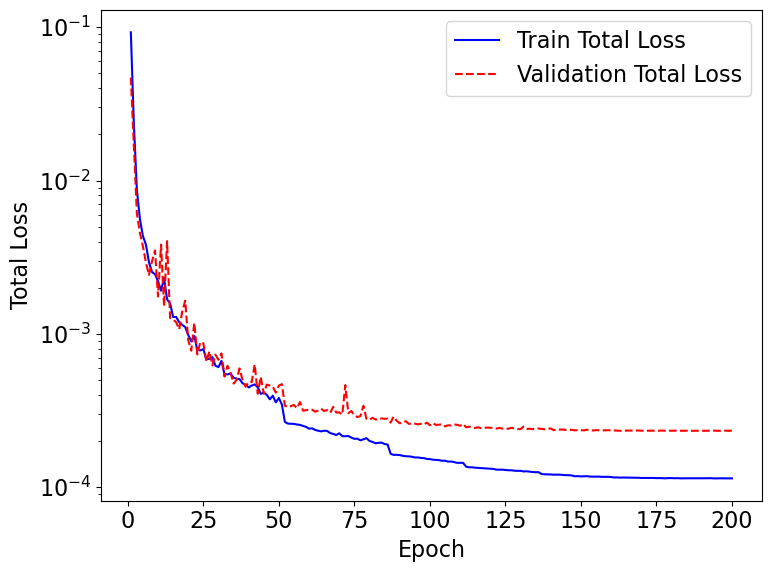

In [48]:
epochs = range(1, len(train_total_hist) + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))

# --- Primary y-axis: total + pressure losses ---
ax1.plot(epochs, train_total_hist, 'b-', label='Train Total Loss')
ax1.plot(epochs, val_total_hist, 'r--', label='Validation Total Loss')
# ax1.plot(epochs, train_p_hist, 'g-', alpha=0.7, label='Train Pressure MSE')
# ax1.plot(epochs, val_p_hist, 'g--', alpha=0.7, label='Val Pressure MSE')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Total Loss")
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,1])
plt.yscale('log')

# --- Secondary y-axis: saturation losses ---
#ax2 = ax1.twinx()
#ax2.plot(epochs, train_s_hist, 'c-', alpha=0.7, label='Train Saturation MSE')
#ax2.plot(epochs, val_s_hist, 'c--', alpha=0.7, label='Val Saturation MSE')
#ax2.set_ylabel("Saturation Loss", color='c')
#ax2.tick_params(axis='y', labelcolor='c')
#plt.yscale('log')

# --- Combined legend ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
#lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 , labels_1 , loc='upper right')


# plt.title("Training and Validation Losses")
plt.tight_layout()
plt.savefig('train_val loss.png', dpi=600)
plt.show()

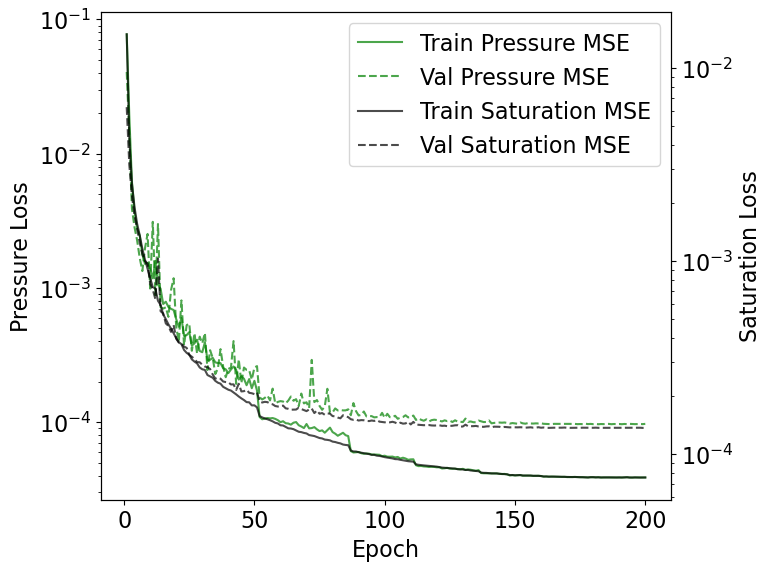

In [53]:
epochs = range(1, len(train_total_hist) + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))

# --- Primary y-axis: total + pressure losses ---
#ax1.plot(epochs, train_total_hist, 'b-', label='Train Total Loss')
#ax1.plot(epochs, val_total_hist, 'r--', label='Validation Total Loss')
ax1.plot(epochs, train_p_hist, 'g-', alpha=0.7, label='Train Pressure MSE')
ax1.plot(epochs, val_p_hist, 'g--', alpha=0.7, label='Val Pressure MSE')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Pressure Loss")
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,1])
plt.yscale('log')

# --- Secondary y-axis: saturation losses ---
ax2 = ax1.twinx()
ax2.plot(epochs, train_s_hist, 'k-', alpha=0.7, label='Train Saturation MSE')
ax2.plot(epochs, val_s_hist, 'k--', alpha=0.7, label='Val Saturation MSE')
ax2.set_ylabel("Saturation Loss", color='k')
ax2.tick_params(axis='y', labelcolor='k')
plt.yscale('log')

# --- Combined legend ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')


#plt.title("Training and Validation Losses")
plt.tight_layout()
plt.savefig('press sat train_val loss.png', dpi=600)
plt.show()

## Test set Evaluation

In [35]:
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [36]:
start_time = time.time()
model.eval()
preds_P, preds_S = [], []
truth_P, truth_S = [], []

with torch.no_grad():
    for X, Y in tqdm(test_loader, desc="Evaluating on test set"):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)

        P_pred, S_pred = pred[:, 0].cpu().numpy(), pred[:, 1].cpu().numpy()
        P_true, S_true = Y[:, 0].cpu().numpy(), Y[:, 1].cpu().numpy()

        preds_P.append(P_pred)
        preds_S.append(S_pred)
        truth_P.append(P_true)
        truth_S.append(S_true)

end_time = time.time()
test_time = end_time - start_time
print("Test time: %.4f" %(test_time))
# concatenate along batch dimension
preds_P = np.concatenate(preds_P, axis=0)
preds_S = np.concatenate(preds_S, axis=0)
truth_P = np.concatenate(truth_P, axis=0)
truth_S = np.concatenate(truth_S, axis=0)


Evaluating on test set: 100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


Test time: 28.8849


## Post processing
### Feel free to ignore anything beneath this

In [38]:
# flatten everything (B, X, Y, Z) → 1D
p_pred_flat = preds_P.flatten()
p_true_flat = truth_P.flatten()
s_pred_flat = preds_S.flatten()
s_true_flat = truth_S.flatten()

metrics = {}

for name, pred, true in [
    ("Pressure", p_pred_flat, p_true_flat),
    ("Saturation", s_pred_flat, s_true_flat),
]:
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    metrics[name] = dict(RMSE=rmse, MAE=mae, R2=r2)

metrics

{'Pressure': {'RMSE': 0.00975166604656453,
  'MAE': 0.004061553161591291,
  'R2': 0.9999052286148071},
 'Saturation': {'RMSE': 0.0042875875761498785,
  'MAE': 0.0009060132433660328,
  'R2': 0.9925707578659058}}

In [39]:
abs_err_P = np.abs(p_pred_flat - p_true_flat)
abs_err_S = np.abs(s_pred_flat - s_true_flat)

percentiles = [10, 50, 90]
p_P = np.percentile(abs_err_P, percentiles)
p_S = np.percentile(abs_err_S, percentiles)

print(f"Pressure Abs Error P10/P50/P90: {p_P}")
print(f"Saturation Abs Error P10/P50/P90: {p_S}")

Pressure Abs Error P10/P50/P90: [0.0002872  0.00169177 0.00940249]
Saturation Abs Error P10/P50/P90: [4.08214801e-05 2.07241072e-04 8.60128889e-04]


/tmp/ipykernel_26662/3416060815.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


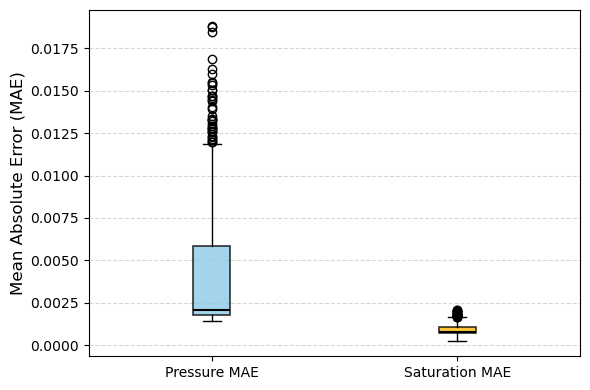

In [40]:
abs_err_P = np.abs(p_pred_flat - p_true_flat)
abs_err_S = np.abs(s_pred_flat - s_true_flat)

percentiles = [10, 50, 90]
p_P = np.percentile(abs_err_P, percentiles)
p_S = np.percentile(abs_err_S, percentiles)


# preds_P, truth_P: shape (N, 35, 35, 11)
# preds_S, truth_S: shape (N, 35, 35, 11)

N = preds_P.shape[0]

mae_P = []
mae_S = []

for i in range(N):
    p_pred = preds_P[i]
    p_true = truth_P[i]
    s_pred = preds_S[i]
    s_true = truth_S[i]

    mae_P.append(np.mean(np.abs(p_pred - p_true)))
    mae_S.append(np.mean(np.abs(s_pred - s_true)))

mae_P = np.array(mae_P)
mae_S = np.array(mae_S)

plt.figure(figsize=(6,4))

data = [mae_P, mae_S]
labels = ["Pressure", "Saturation"]
colors = ['#8ecae6', '#ffb703']

bp = plt.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    medianprops=dict(color='black', linewidth=1.5),
    whiskerprops=dict(color='black'),
    boxprops=dict(linewidth=1.2, color='black')
)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set(facecolor=color, alpha=0.8)

plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

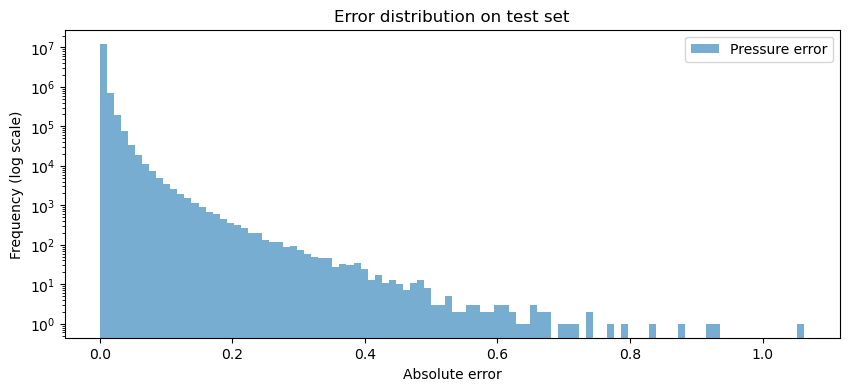

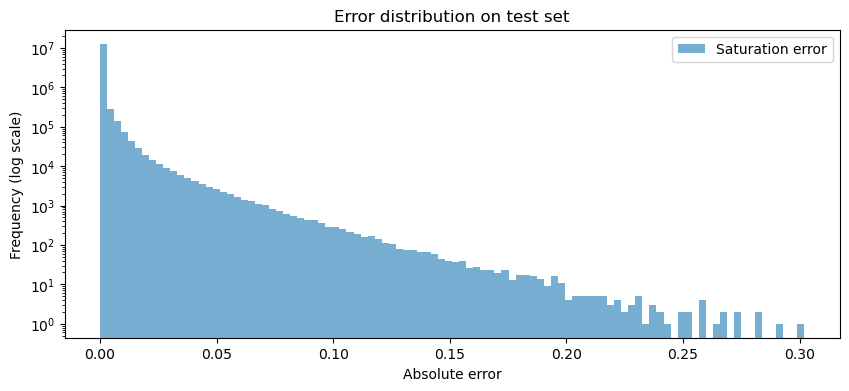

In [41]:
plt.figure(figsize=(10,4))
plt.hist(abs_err_P, bins=100, alpha=0.6, label="Pressure error")
plt.yscale('log')
plt.xlabel("Absolute error")
plt.ylabel("Frequency (log scale)")
plt.legend()
plt.title("Error distribution on test set")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(abs_err_S, bins=100, alpha=0.6, label="Saturation error")
plt.yscale('log')
plt.xlabel("Absolute error")
plt.ylabel("Frequency (log scale)")
plt.legend()
plt.title("Error distribution on test set")
plt.show()

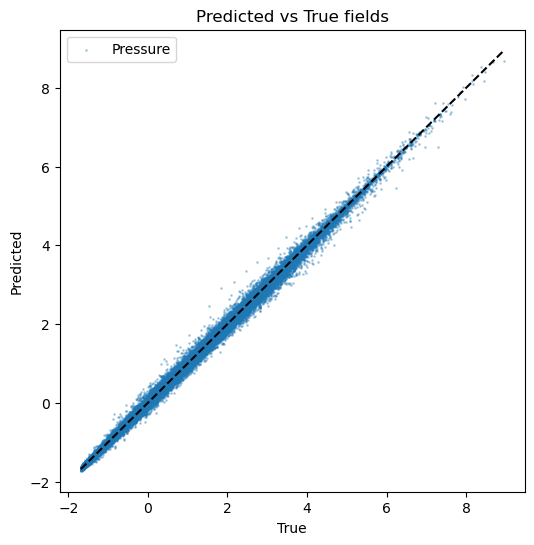

In [43]:
plt.figure(figsize=(6,6))
plt.scatter(p_true_flat, p_pred_flat, s=1, alpha=0.3, label="Pressure")
#plt.scatter(s_true_flat, s_pred_flat, s=1, alpha=0.3, label="Saturation")
plt.plot([p_true_flat.min(), p_true_flat.max()],
         [p_true_flat.min(), p_true_flat.max()],
         'k--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs True fields")
plt.show()


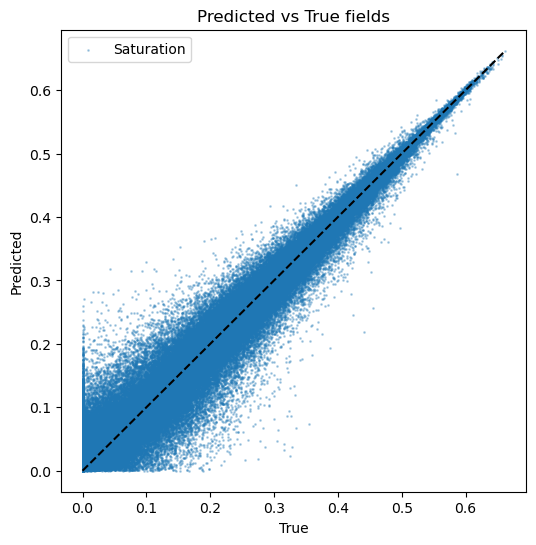

In [44]:
plt.figure(figsize=(6,6))
#plt.scatter(p_true_flat, p_pred_flat, s=1, alpha=0.3, label="Pressure")
plt.scatter(s_true_flat, s_pred_flat, s=1, alpha=0.3, label="Saturation")
plt.plot([s_true_flat.min(), s_true_flat.max()],
         [s_true_flat.min(), s_true_flat.max()],
         'k--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs True fields")
plt.show()

In [41]:
# 3D plotting helper function
def plotter3D(vars_3d, title):
    nx, ny, nz = vars_3d.shape
    #norm = matplotlib.colors.Normalize(vmin=np.min(vars_3d), vmax=np.max(vars_3d))
    norm = matplotlib.colors.Normalize(vmin=np.min(vars_3d), vmax=np.max(vars_3d))
    x, y, z = np.indices((nx + 1, ny + 1, nz + 1))
    
    plt.rc('font', size=12)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
    # ax.set_box_aspect((1, 1, 1))
    #ax.invert_zaxis()
    ax.invert_yaxis()
    # ax.invert_xaxis()
    
    ax.set_axis_off()
    
    # Add axis direction labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    
    # Hide ticks and grid lines, but keep labels
    ax.grid(False)  # Disable grid lines
    
    ax.view_init(elev=30, azim=0)  # 60, -60
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 1, 1]))
    # plotting black boundary box
    ax.plot3D([0, nx], [0, 0], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, nx], [0, 0], [nz, nz], 'k', linewidth=0.5)
    ax.plot3D([0, nx], [ny, ny], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, nx], [ny, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [0, ny], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [0, ny], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [0, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [0, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [ny, ny], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [0, 0], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [0, 0], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [ny, ny], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    
    
    colors = plt.cm.jet(norm(vars_3d.transpose((0, 1, 2))))
    filled = np.where(vars_3d.transpose((0, 1, 2)) > 0, np.ones((nx, ny, nz)), np.zeros((nx, ny, nz)))
    
    vox = ax.voxels(x, y, z, filled, facecolors=colors,
                    edgecolors=colors,  # brighter
                    linewidth=0.5,
                    alpha=1, shade=False)
    
    
    m = cm.ScalarMappable(cmap=cm.jet, norm=norm)
    m.set_array([])
    plt.colorbar(m, ax=ax, shrink=0.5, pad=0.001)
    # plt.title(title)
    plt.tight_layout()
    # plt.savefig(title+'.png', dpi=600)
    plt.show()

In [50]:
preds_P.shape, truth_P.shape, preds_S.shape, truth_S.shape

((1000, 35, 35, 11),
 (1000, 35, 35, 11),
 (1000, 35, 35, 11),
 (1000, 35, 35, 11))

In [42]:
example = 5

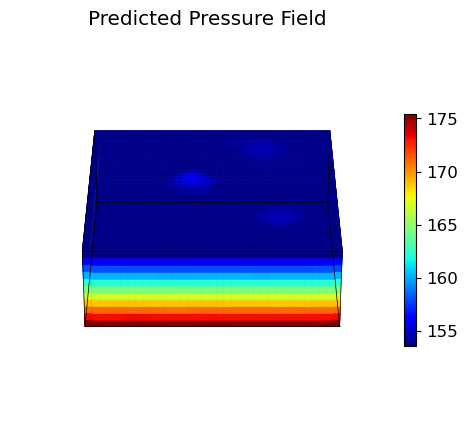

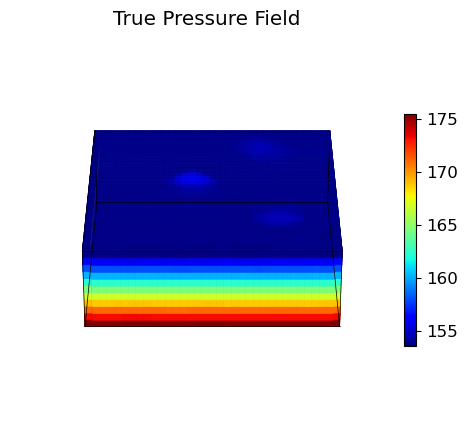

In [66]:
res_p_p = ((preds_P[example] * P_SIGMA) + P_MU) / 1e5
res_p_t = ((truth_P[example] * P_SIGMA) + P_MU) / 1e5
plotter3D(res_p_p, 'Predicted Pressure Field')
plotter3D(res_p_t, 'True Pressure Field')

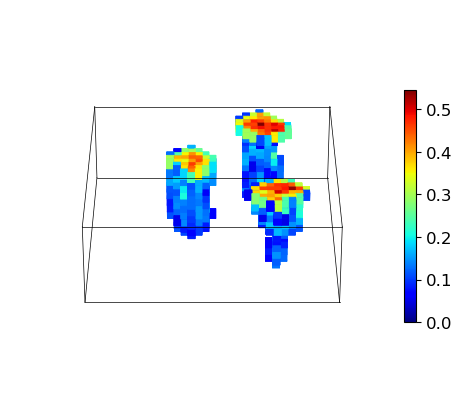

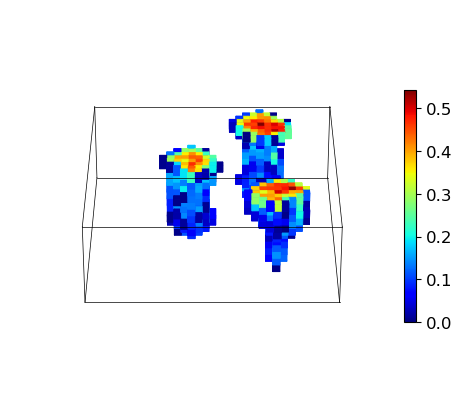

In [43]:
res_s_p = preds_S[example].copy()     # (35, 35, 11)
res_s_p[res_s_p < 0.05] = 0.0         # zero out small saturations
res_s_t = truth_S[example]
plotter3D(res_s_p, 'Predicted Saturation Field')
plotter3D(res_s_t, 'True Saturation Field')